In [ ]:
#      Convolutional network VGG16
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# versión reducida
from google.colab import drive

drive.mount('/content/drive')

import zipfile
import os

# Ruta a la carpeta donde están tus archivos zip
base_zip_path = ('/content/drive/My Drive/Redes_Neuronales/')

# Directorios para extraer los contenidos
data_dir = '/content/data_reducida'
test_dir = '/content/test_reducido'

# Descomprimir data.zip
with zipfile.ZipFile(base_zip_path + 'data_reducida.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Descomprimir test.zip
with zipfile.ZipFile(base_zip_path + 'test_reducido.zip', 'r') as zip_ref:
    zip_ref.extractall(test_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

In [ ]:
# Para extraer las imágenes

from google.colab import drive

drive.mount('/content/drive')

import zipfile
import os

# Ruta a la carpeta donde están tus archivos zip
base_zip_path = ('/content/drive/My Drive/Redes_Neuronales/')

# Directorios para extraer los contenidos
data_dir = '/content/data'
test_dir = '/content/test'

# Descomprimir data.zip
with zipfile.ZipFile(base_zip_path + 'data.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Descomprimir test.zip
with zipfile.ZipFile(base_zip_path + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(test_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=data_dir, target_size=(224,224))

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_dir, target_size=(224,224))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    'vgg16.keras',  # Cambia la extensión de .h5 a .keras
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

early = EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0,
    patience=10,
    verbose=1,
    mode='auto'
)

In [ ]:
# function to extract iterations
from collections import deque
import keras.callbacks

class BatchHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_losses = []
        self.epoch_accuracy = []
        self.batch_losses = []
        self.batch_accuracy = []
        self.log_every_n_batches = 3  # Define cada cuántos batches quieres registrar

    def on_batch_end(self, batch, logs=None):
        if batch % self.log_every_n_batches == 0:  # Solo registrar cada 10 batches
            self.batch_losses.append(logs.get('loss'))
            self.batch_accuracy.append(logs.get('accuracy'))

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_losses.append(self.batch_losses)
        self.epoch_accuracy.append(self.batch_accuracy)
        self.batch_losses = []
        self.batch_accuracy = []


In [ ]:
batch_history = BatchHistory()
hist = model.fit(
    traindata,
    steps_per_epoch=100,
    validation_data=testdata,
    validation_steps=10,
    epochs=100,
    callbacks=[checkpoint, early, batch_history]
)

Epoch 1/100
 51/100 [==============>...............] - ETA: 57:30 - loss: 0.8824 - accuracy: 0.5116

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Performance")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy", "Validation Accuracy", "Train Loss", "Validation Loss"], loc='upper left')
plt.show()

NameError: name 'hist' is not defined

In [ ]:
import matplotlib.pyplot as plt

# x-axis, accuracy, and loss values
epoch_points = []
accuracies = []
losses = []

# Calcular x-axis posición para accuracy y loss 
for epoch_idx, (batch_acc, batch_loss) in enumerate(zip(batch_history.epoch_accuracy, batch_history.epoch_losses)):
    for batch_idx, (acc, loss) in enumerate(zip(batch_acc, batch_loss)):
        offset = batch_idx / len(batch_acc)
        epoch_points.append(epoch_idx + offset)
        accuracies.append(acc)
        losses.append(loss)

# Plot para accuracy
plt.figure(figsize=(15, 5))
plt.plot(epoch_points, accuracies, label='Batch Training Accuracy')  
plt.plot(hist.history['val_accuracy'], label='Val Accuracy')  
plt.title('Batch Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(list(range(1, len(batch_history.epoch_accuracy) + 1)))  # Set x-axis ticks to match epochs
plt.show()

# Plot para loss
plt.figure(figsize=(15, 5))
plt.plot(epoch_points, losses, label='Batch Training Loss', color='red')  
plt.plot(hist.history['val_loss'], label='Val Loss')  
plt.title('Batch Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(list(range(1, len(batch_history.epoch_losses) + 1)))  
plt.show()

NameError: name 'batch_history' is not defined

1/1 [==============================] - 0s 134ms/step
cat
1/1 [==============================] - 0s 141ms/step


NameError: name 'pyplot' is not defined

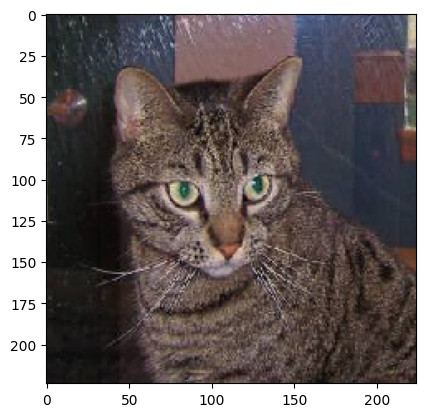

In [ ]:
from keras.preprocessing import image
img = image.load_img("image.jpg",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model("vgg16.keras")
output = saved_model.predict(img)
if output[0][0] > output[0][1]:
    print("cat")
else:
    print('dog')


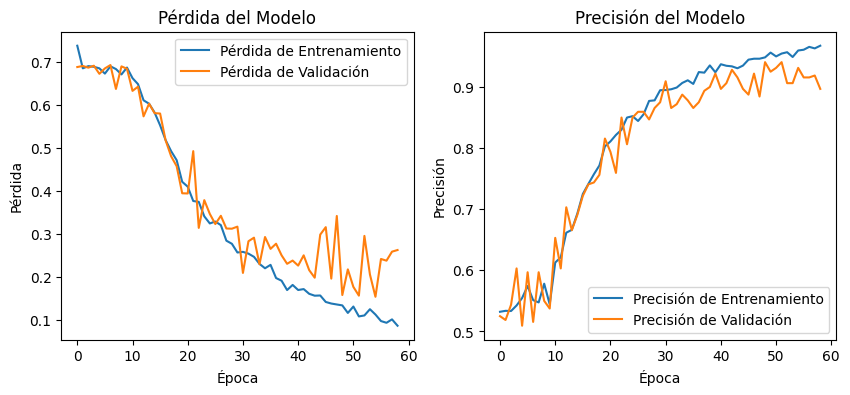

In [ ]:
# Datos de pérdida
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(hist.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()

# Datos de precisión
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(hist.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()

plt.show()